In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import rawpy as raw
from peakutils import peak
from scipy import integrate, interpolate as interp, signal as sig, stats as stat
from jupyterthemes import jtplot

In [ ]:
jtplot.reset()
# plt.switch_backend('nbAgg')
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}", r"\usepackage{url}"]

In [ ]:
class ROISelect:
    def __init__(self, image):
        self.image = image
        self.cropping = False
        self.sel_rect_endpoint = None
        self.refpt = None
        
    def ColorPicker(self, event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            self.refpt = [(x, y)]
            self.cropping = True

        elif event == cv.EVENT_LBUTTONUP:
            self.refpt.append((x, y))
            self.cropping = False

            cv.rectangle(self.image, self.refpt[0], self.refpt[1], (0, 255, 0), 2)
            cv.imshow('macbeth', self.image)

        elif event == cv.EVENT_MOUSEMOVE and self.cropping:
            self.sel_rect_endpoint = [(x, y)]

    def get_ROI(self):
        image = (self.image/self.image.max()).astype('float32')
        clone = image.copy()
        cv.namedWindow('macbeth', cv.WINDOW_NORMAL)
        if image.shape[0] > image.shape[1]:
            cv.resizeWindow('macbeth', 400, 600)
        else:
            cv.resizeWindow('macbeth', 600, 400)
        cv.setMouseCallback('macbeth', self.ColorPicker)

        while True:
            if not self.cropping:
                cv.imshow('macbeth', self.image)
            elif self.cropping and self.sel_rect_endpoint:
                rect_cpy = image.copy()
                cv.rectangle(rect_cpy, self.refpt[0], self.sel_rect_endpoint[0], (0, 255, 0), 1)
                cv.imshow('macbeth', rect_cpy)

            key = cv.waitKey(1) & 0xFF
            if key == ord('r'):
                image = clone.copy()

            elif key == ord('c'):
                break

        if len(self.refpt) == 2:
            self.roi = clone[self.refpt[0][1]:self.refpt[1][1], self.refpt[0][0]:self.refpt[1][0]]
            cv.imshow("ROI", self.roi)
            cv.waitKey(0)

        cv.destroyAllWindows()
        return self.roi

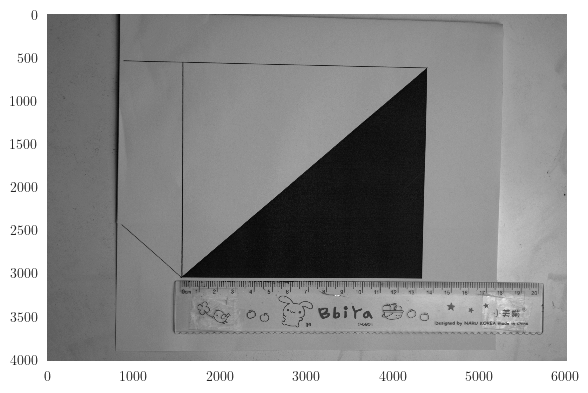

In [4]:
img_raw = raw.imread('raw/_KVD7149.NEF')
img = img_raw.postprocess(use_camera_wb=True,
                          output_bps=8,
                          no_auto_bright=True)
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
plt.imshow(img, 'gray')
plt.grid(0)
plt.show()

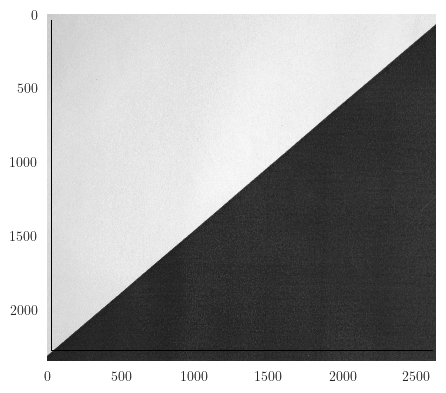

In [6]:
rois = ROISelect(img)
roi = rois.get_ROI()
plt.imshow(roi, 'gray')
plt.grid(0)
plt.show()

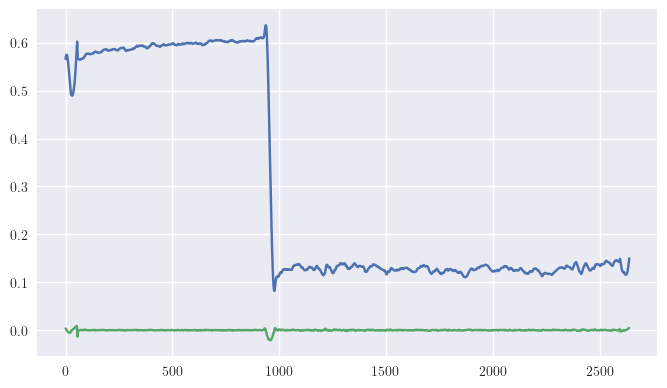

In [12]:
filt = sig.savgol_filter(roi[1500], 51, 3)
plt.plot(filt)
plt.plot(np.gradient(filt))
plt.show()